# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [68]:
# import libraries
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import IntegerType, FloatType
from pyspark.ml.classification import LogisticRegression, LinearSVC, RandomForestClassifier
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.mllib.evaluation import MulticlassMetrics
import re
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# create a Spark session
spark = SparkSession \
        .builder \
        .master("local") \
        .appName("FinalProjectNew") \
        .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
data = spark.read.json("mini_sparkify_event_data.json")

In [4]:
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### Missing Values

In [5]:
# Drop any rows with missing values in UserId or SessionId columns
print("# rows before: " + str(data.count()))
print("# rows after: " + str(data.dropna(how = "any", subset = ["userId", "sessionId"]).count()))

# rows before: 286500
# rows after: 286500


Apparently there are no missing values in those columns, however it seems that userId contains unusual values:

In [6]:
# Check unique values for userId
data.select('userId').dropDuplicates().orderBy('userId').show(5)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
+------+
only showing top 5 rows



In [7]:
# Remove blank userId and check again
cleaned_data = data.where(data.userId != '').dropDuplicates()
cleaned_data.select('userId').dropDuplicates().orderBy('userId').show(5)

+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
+------+
only showing top 5 rows



In [8]:
# Check if the same problem can be found in sessionId
cleaned_data.select('sessionId').dropDuplicates().orderBy('sessionId').show(5)

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
+---------+
only showing top 5 rows



There are other missing values, yet we will keep all the rows that can be identified by userId and sessionID

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [9]:
# Size of dataset
print("The dataset has shape: ({}, {})".format(cleaned_data.count(), len(cleaned_data.columns)))

The dataset has shape: (278154, 18)


In [10]:
# Total number of users
tot_users = cleaned_data.select('userId').dropDuplicates()
tot_users.count()

225

In [11]:
# Page column
cleaned_data.select('page').drop_duplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [12]:
# Tag cancellation with a new column
tagged_data = cleaned_data.withColumn('cancel', cleaned_data.page == 'Cancellation Confirmation')
tagged_data.select('userId', 'page','cancel').show(5)

+------+-----------+------+
|userId|       page|cancel|
+------+-----------+------+
|    78|   NextSong| false|
|    78|Thumbs Down| false|
|    25|   NextSong| false|
|    15|   NextSong| false|
|    27|       Home| false|
+------+-----------+------+
only showing top 5 rows



In [13]:
# Find users who has canceled
canc_users = tagged_data.select('userId').where(tagged_data.cancel == 'true').dropDuplicates()
print(canc_users.count())

52


In [14]:
# Prepare Dataframe
X = tot_users.orderBy('userId')

In [15]:
# Add targets
list_canc = list(canc_users.orderBy('userId').toPandas()['userId'].values)
insert_targets = udf(lambda user: 1 if (user in list_canc) else 0, IntegerType())
X = X.withColumn('target', insert_targets(X.userId))
X.show(5)

+------+------+
|userId|target|
+------+------+
|    10|     0|
|   100|     0|
|100001|     1|
|100002|     0|
|100003|     1|
+------+------+
only showing top 5 rows



In [16]:
# How many users have cancelled and how many are still registered?
X.groupBy('target').count().show()

+------+-----+
|target|count|
+------+-----+
|     1|   52|
|     0|  173|
+------+-----+



173 users are still registered, while 52 users have canceled the account

### Page Activity

In [17]:
# Create dataframe with one row for each user and one column for each page, each entry is the count activity for the respecitives user-page
page_df = cleaned_data.select('userId','page').groupBy('userId','page').count().orderBy('userId','page').groupBy('userId').pivot('page').sum('count')

# Replace null values with 0s
page_df = page_df.na.fill(0)

# Check one row
page_df.show(1)

+------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|userId|About|Add Friend|Add to Playlist|Cancel|Cancellation Confirmation|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|
+------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|200002|    3|         4|              8|     0|                        0|        5|    0|   2|  20|     5|     387|          7|            0|       3|               0|             1|          6|       21|      2|
+------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--

In [18]:
# Join to main dataset
X = X.join(page_df, on='userId', how='left')
X.show(3)

+------+------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|userId|target|About|Add Friend|Add to Playlist|Cancel|Cancellation Confirmation|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|
+------+------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|   100|     0|   12|        49|             61|     0|                        0|       30|    3|  18| 105|    35|    2682|         25|            5|      11|               1|             1|         27|      148|      1|
|    10|     0|    2|        12|              9|     0|                        0|        7|    0|   1|  30|    11|  

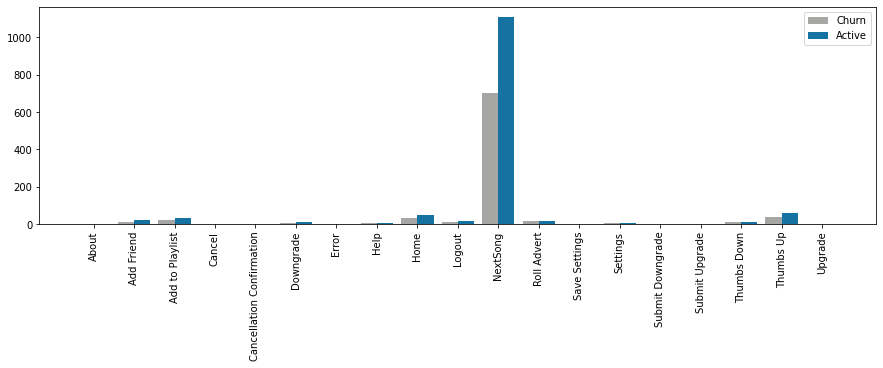

In [19]:
# Explore Churn vs Active
churn_df_page = X.where(X.target == 1).toPandas().iloc[:,2:]
active_df_page = X.where(X.target == 0).toPandas().iloc[:,2:]

# Plot means for each group
fig, ax = plt.subplots(figsize=(15,4))
ax.bar(x=np.arange(len(churn_df_page.mean()))-0.2, height=churn_df_page.mean(), width=0.4, color='#A6A6A4')
ax.bar(x=np.arange(len(active_df_page.mean()))+0.2, height=active_df_page.mean(), width=0.4, color='#1572A1')
plt.xticks(np.arange(len(active_df_page.mean())), churn_df_page.columns, rotation=90)
plt.legend(['Churn', 'Active']);

### Famous Artists

In [20]:
# Find most popular artists with >= N song listened
n = 500
ordered_artists = cleaned_data.select('artist').dropna().groupBy('artist').count().orderBy('count', ascending=False)
famous_artists = ordered_artists.where(ordered_artists['count'] > n)

# Create dataframe with one row for each user and one column representing how many songs from famous artists the user has listened to
artist_df = cleaned_data.select('userId','artist').where(cleaned_data.artist.isin(list(famous_artists.toPandas()['artist'].values))).groupBy('userId','artist').count().orderBy('userID','count', ascending=False)
user_famous_df = artist_df.groupBy('userId').agg(F.sum('count').alias('famous_artists'))
user_famous_df.show(5)

+------+--------------+
|userId|famous_artists|
+------+--------------+
|200002|            52|
|100010|            33|
|   125|             1|
|    51|           262|
|   124|           554|
+------+--------------+
only showing top 5 rows



In [21]:
# Join to main dataset
X = X.join(user_famous_df, on='userId', how='left').na.fill(0)
X.take(3)

[Row(userId='100', target=0, About=12, Add Friend=49, Add to Playlist=61, Cancel=0, Cancellation Confirmation=0, Downgrade=30, Error=3, Help=18, Home=105, Logout=35, NextSong=2682, Roll Advert=25, Save Settings=5, Settings=11, Submit Downgrade=1, Submit Upgrade=1, Thumbs Down=27, Thumbs Up=148, Upgrade=1, famous_artists=322),
 Row(userId='10', target=0, About=2, Add Friend=12, Add to Playlist=9, Cancel=0, Cancellation Confirmation=0, Downgrade=7, Error=0, Help=1, Home=30, Logout=11, NextSong=673, Roll Advert=1, Save Settings=1, Settings=7, Submit Downgrade=0, Submit Upgrade=0, Thumbs Down=4, Thumbs Up=37, Upgrade=0, famous_artists=79),
 Row(userId='100001', target=1, About=0, Add Friend=2, Add to Playlist=3, Cancel=1, Cancellation Confirmation=1, Downgrade=0, Error=1, Help=1, Home=11, Logout=7, NextSong=133, Roll Advert=14, Save Settings=0, Settings=1, Submit Downgrade=0, Submit Upgrade=0, Thumbs Down=2, Thumbs Up=8, Upgrade=2, famous_artists=16)]

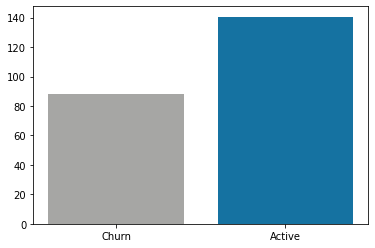

In [22]:
# Explore Churn vs Active
churn_df_artist = X.where(X.target == 1).toPandas().loc[:,'famous_artists']
active_df_artist = X.where(X.target == 0).toPandas().loc[:,'famous_artists']

# Plot means for each group
plt.bar(x=[0,1], height=[churn_df_artist.mean(),active_df_artist.mean()], color=['#A6A6A4','#1572A1'])
plt.xticks([0,1], ['Churn', 'Active']);

### Subscription Level

In [23]:
# Find users with paid level
paid_level = udf(lambda paid_count : 0 if paid_count is None else 1, IntegerType())
paid_df = cleaned_data.select('userId','level').groupBy('userId','level').count().orderBy('userId', 'level').groupBy('userId').pivot('level').sum('count')
paid_df = paid_df.withColumn('pay', paid_level(paid_df.paid)).drop('free','paid')
paid_df.show(5)

+------+---+
|userId|pay|
+------+---+
|200002|  1|
|100010|  0|
|   125|  0|
|     7|  0|
|   124|  1|
+------+---+
only showing top 5 rows



In [24]:
# Join to main dataset
X = X.join(paid_df, on='userId', how='left')
X.take(3)

[Row(userId='100', target=0, About=12, Add Friend=49, Add to Playlist=61, Cancel=0, Cancellation Confirmation=0, Downgrade=30, Error=3, Help=18, Home=105, Logout=35, NextSong=2682, Roll Advert=25, Save Settings=5, Settings=11, Submit Downgrade=1, Submit Upgrade=1, Thumbs Down=27, Thumbs Up=148, Upgrade=1, famous_artists=322, pay=1),
 Row(userId='10', target=0, About=2, Add Friend=12, Add to Playlist=9, Cancel=0, Cancellation Confirmation=0, Downgrade=7, Error=0, Help=1, Home=30, Logout=11, NextSong=673, Roll Advert=1, Save Settings=1, Settings=7, Submit Downgrade=0, Submit Upgrade=0, Thumbs Down=4, Thumbs Up=37, Upgrade=0, famous_artists=79, pay=1),
 Row(userId='100001', target=1, About=0, Add Friend=2, Add to Playlist=3, Cancel=1, Cancellation Confirmation=1, Downgrade=0, Error=1, Help=1, Home=11, Logout=7, NextSong=133, Roll Advert=14, Save Settings=0, Settings=1, Submit Downgrade=0, Submit Upgrade=0, Thumbs Down=2, Thumbs Up=8, Upgrade=2, famous_artists=16, pay=0)]

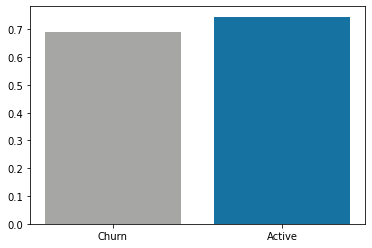

In [25]:
# Explore Churn vs Active
churn_df_paid = X.where(X.target == 1).toPandas().loc[:,'pay']
active_df_paid = X.where(X.target == 0).toPandas().loc[:,'pay']

# Plot means for each group
plt.bar(x=[0,1], height=[churn_df_paid.mean(),active_df_paid.mean()], color=['#A6A6A4','#1572A1'])
plt.xticks([0,1], ['Churn', 'Active']);

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [26]:
X.take(1)

[Row(userId='10', target=0, About=2, Add Friend=12, Add to Playlist=9, Cancel=0, Cancellation Confirmation=0, Downgrade=7, Error=0, Help=1, Home=30, Logout=11, NextSong=673, Roll Advert=1, Save Settings=1, Settings=7, Submit Downgrade=0, Submit Upgrade=0, Thumbs Down=4, Thumbs Up=37, Upgrade=0, famous_artists=79, pay=1)]

In [27]:
# Assess weather all variables have roughly the same standard deviation
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col

columns = ['About', 'Add Friend', 'Add to Playlist', 
                                       'Downgrade', 'Error', 'Help', 'Home', 'Logout', 
                                       'NextSong', 'Roll Advert', 'Save Settings', 'Settings', 
                                       'Submit Downgrade', 'Submit Upgrade', 'Thumbs Down', 'Thumbs Up', 
                                       'Upgrade', 'famous_artists', 'pay']

# Iterating over columns to be scaled
for i in columns:
    df_stats = X.select(
        _mean(col(i)).alias('mean'),
        _stddev(col(i)).alias('std')
    ).collect()
    mean = df_stats[0]['mean']
    std = df_stats[0]['std']
    print(f"{i} - Mean: {mean}, Std: {std}")

About - Mean: 2.2, Std: 3.119638257417493
Add Friend - Mean: 19.00888888888889, Std: 20.581716728496275
Add to Playlist - Mean: 29.004444444444445, Std: 32.716653931055426
Downgrade - Mean: 9.133333333333333, Std: 11.73441215278501
Error - Mean: 1.12, Std: 1.4726070176973314
Help - Mean: 6.4622222222222225, Std: 7.2425851519011974
Home - Mean: 44.80888888888889, Std: 47.296121774630045
Logout - Mean: 14.337777777777777, Std: 15.346347996360464
NextSong - Mean: 1013.8133333333334, Std: 1104.9607785540882
Roll Advert - Mean: 17.48, Std: 21.5502071584342
Save Settings - Mean: 1.3777777777777778, Std: 1.7357698077212964
Settings - Mean: 6.728888888888889, Std: 6.9835464224791
Submit Downgrade - Mean: 0.28, Std: 0.5876709477736183
Submit Upgrade - Mean: 0.7066666666666667, Std: 0.7338742593737899
Thumbs Down - Mean: 11.315555555555555, Std: 13.077481251105503
Thumbs Up - Mean: 55.782222222222224, Std: 65.47792460907044
Upgrade - Mean: 2.2177777777777776, Std: 2.55853690829566
famous_artists

Features distributions seems very different, standardize them might be misleading: https://quantifyinghealth.com/standardized-vs-unstandardized-regression-coefficients/.

So I will continue to train the model with non-scaled features.

In [28]:
assembler = VectorAssembler(inputCols=['About', 'Add Friend', 'Add to Playlist', 
                                       'Downgrade', 'Error', 'Help', 'Home', 'Logout', 
                                       'NextSong', 'Roll Advert', 'Save Settings', 'Settings', 
                                       'Submit Downgrade', 'Submit Upgrade', 'Thumbs Down', 'Thumbs Up', 
                                       'Upgrade', 'famous_artists', 'pay'], outputCol = 'features')
all_data = assembler.transform(X)
all_data.take(1)

[Row(userId='10', target=0, About=2, Add Friend=12, Add to Playlist=9, Cancel=0, Cancellation Confirmation=0, Downgrade=7, Error=0, Help=1, Home=30, Logout=11, NextSong=673, Roll Advert=1, Save Settings=1, Settings=7, Submit Downgrade=0, Submit Upgrade=0, Thumbs Down=4, Thumbs Up=37, Upgrade=0, famous_artists=79, pay=1, features=DenseVector([2.0, 12.0, 9.0, 7.0, 0.0, 1.0, 30.0, 11.0, 673.0, 1.0, 1.0, 7.0, 0.0, 0.0, 4.0, 37.0, 0.0, 79.0, 1.0]))]

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [29]:
# Split in train and test data
data = all_data.select('target', 'features')
(train_data, test_data) = data.randomSplit([0.75, 0.25])
train_data.take(1)

[Row(target=0, features=SparseVector(19, {0: 1.0, 1: 7.0, 2: 3.0, 6: 10.0, 7: 2.0, 8: 178.0, 9: 17.0, 11: 1.0, 14: 2.0, 15: 14.0, 17: 21.0}))]

In [30]:
# Model tuning and validation
rfc = RandomForestClassifier(featuresCol='features', labelCol='target')
ev = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='target', metricName='f1')

# Define parameters for grid search
paramGrid = ParamGridBuilder() \
    .addGrid(rfc.numTrees, [10, 20, 40]) \
    .addGrid(rfc.maxDepth, [4, 5, 6]) \
.build()

# Define cross validation parameters
crossval = CrossValidator(estimator=rfc,
                         estimatorParamMaps=paramGrid,
                         evaluator=ev,
                         numFolds=3)

# Perform Cross-Validation
cvModel_rfc = crossval.fit(train_data)

In [34]:
# Show different parameters performance
scores = cvModel_rfc.avgMetrics
param_maps = cvModel_rfc.getEstimatorParamMaps()
for n, param_map in enumerate(cvModel_rfc.getEstimatorParamMaps()):
    params = [(p[0].name, p[1]) for p in param_map.items()]
    print(f"Score:{cvModel_rfc.avgMetrics[n]} - Parameters:{params}")

Score:0.7039377164400474 - Parameters:[('numTrees', 10), ('maxDepth', 4)]
Score:0.6949550240907921 - Parameters:[('numTrees', 10), ('maxDepth', 5)]
Score:0.706604964254495 - Parameters:[('numTrees', 10), ('maxDepth', 6)]
Score:0.7097611499364369 - Parameters:[('numTrees', 20), ('maxDepth', 4)]
Score:0.7039377164400474 - Parameters:[('numTrees', 20), ('maxDepth', 5)]
Score:0.6978903047322583 - Parameters:[('numTrees', 20), ('maxDepth', 6)]
Score:0.7097611499364369 - Parameters:[('numTrees', 40), ('maxDepth', 4)]
Score:0.7068766454943001 - Parameters:[('numTrees', 40), ('maxDepth', 5)]
Score:0.7286086285540305 - Parameters:[('numTrees', 40), ('maxDepth', 6)]


In [32]:
# Select Best Model
BestModel_rfc = cvModel_rfc.bestModel

In [ ]:
# Save the best model
BestModel_rfc.write().overwrite().save("cvModel_rfc")

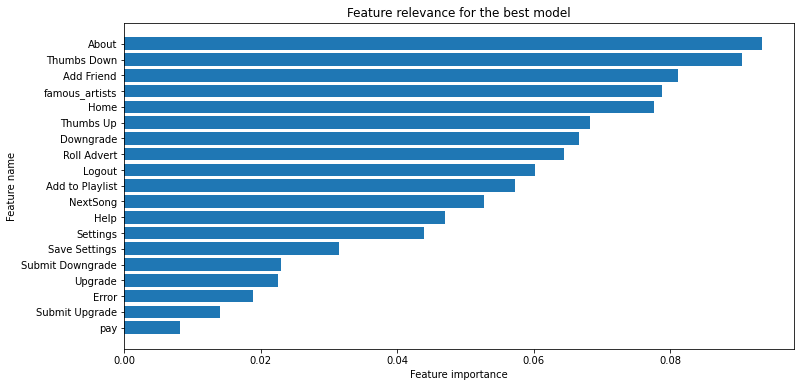

In [35]:
# Extract feature importance
coefficients = BestModel_rfc.featureImportances.toArray()
sort_indx = np.argsort(coefficients)
sort_coeff = coefficients[sort_indx]

# Plot feature importance
plt.figure(figsize = [12, 6])
plt.barh(np.arange(len(sort_coeff)), sort_coeff)
plt.title("Feature relevance for the best model")
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.yticks(np.arange(len(sort_coeff)), np.array(columns)[sort_indx]);

In [46]:
# Extract model metrics
preds = BestModel_rfc.transform(test_data)
preds_and_labels = preds.select(['prediction','target']).withColumn('label', F.col('target').cast(FloatType())).orderBy('prediction').select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

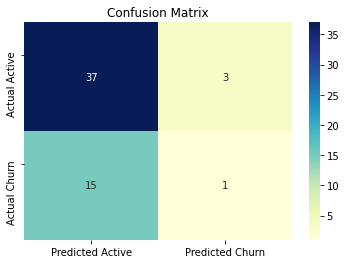

In [86]:
# Plot confusion matrix
sns.heatmap(metrics.confusionMatrix().toArray(), cmap="YlGnBu", annot=metrics.confusionMatrix().toArray())
plt.xticks(np.arange(2)+0.5, ['Predicted Active', 'Predicted Churn'])
plt.yticks(np.arange(2)+0.3, ['Actual Active', 'Actual Churn'])
plt.title("Confusion Matrix");

In [90]:
# Print model metrics
print(f"- f measure class 0 (active users): {metrics.fMeasure(.0)}")
print(f"- f measure class 1 (churn users): {metrics.fMeasure(1.0)}")
print(f"- weighted true/positive rate: {metrics.weightedTruePositiveRate}")

- f measure class 0 (active users): 0.8043478260869567
- f measure class 1 (churn users): 0.1
- weighted true/positive rate: 0.6785714285714286


#### Performance

The performance of the model is not ideal. 
Looking at the confusion matrix it is clear that the model has suffered the problem of class imbalance. There are a lot of false negatives (churns predicted as active users) only because active users were much more frequent in the dataset.

The f-metric confirms that, with a f-score of 0.80 for class 0 and a f-score of 0.1 for class 1.

The overall True / Positive ration is around 0.68, however our buisness case is more focussed on correctly identifying true positives.

#### Features

Besides performance, the model can give some insights on which features might be more relevant in this task.
Features regarding page activities like "Add Friend", "Thumbs down", "Add to playlist" and "Downgrade" share the most importance. 
On the other side the binary feature regarding user subscription level ("paid/free") was not relevant to the model.

#### Improvements

There are a lot of improvements that could be applyed to the project. The data used are just a little portion of a bigger dataset that is available to be analyzed.
To analyze a bigger dataset could be a great opportunity to use a cloud computing service (e.g. AWS) and exploit all the power of spark in a distributed system.
The model selection could be done via testing various models with a portion of the dataset, selecting the best suited for the current task.
Moreover, the classes are imbalanced. Therefore, a downsapling / upsampling approach could be beneficial to the training.
Finally, the model tuning could be improved adding extra hyper-parameters in the grid-search.